<a href="https://colab.research.google.com/github/furygrim/Brain-Tumor-Segmentation/blob/main/BrainTumorUnetSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nikhilroxtomar_brain_tumor_segmentation_path = kagglehub.dataset_download('nikhilroxtomar/brain-tumor-segmentation')

print('Data source import complete.')


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import *

2025-04-28 17:51:15.386123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745862675.590241      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745862675.650090      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
IMAGE_SIZE = 256
DATASET_PATH = "/kaggle/input/brain-tumor-segmentation"

def load_data(image_path, mask_path):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_path))
    mask_files = sorted(os.listdir(mask_path))

    for img_file, mask_file in zip(image_files, mask_files):
        # Load image in color, convert to RGB, and resize
        img = cv2.imread(os.path.join(image_path, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        img = img / 255.0  # Normalize

        mask = cv2.imread(os.path.join(mask_path, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
        mask = mask / 255.0  # Normalize

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


image_path = os.path.join(DATASET_PATH, "images")  # Change according to dataset
mask_path = os.path.join(DATASET_PATH, "masks")


X, Y = load_data(image_path, mask_path)






X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=42
)


X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42)


print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (2144, 256, 256, 3)
Y_train shape: (2144, 256, 256)
X_val shape: (460, 256, 256, 3)
Y_val shape: (460, 256, 256)
X_test shape: (460, 256, 256, 3)
Y_test shape: (460, 256, 256)


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_reduced_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)

    b1 = conv_block(p3, 512)

    d1 = decoder_block(b1, s3, 64)
    d2 = decoder_block(d1, s2, 32)
    d3 = decoder_block(d2, s1, 16)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    model = Model(inputs, outputs, name="Reduced_UNET")

    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_reduced_unet(input_shape)
    model.summary()

I0000 00:00:1745862762.815983      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745862762.816730      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "Reduced_UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 3,020,017 (11.52 MB)

 Trainable params: 3,017,073 (11.51 MB)

 Non-trainable params: 2,944 (11.50 KB)

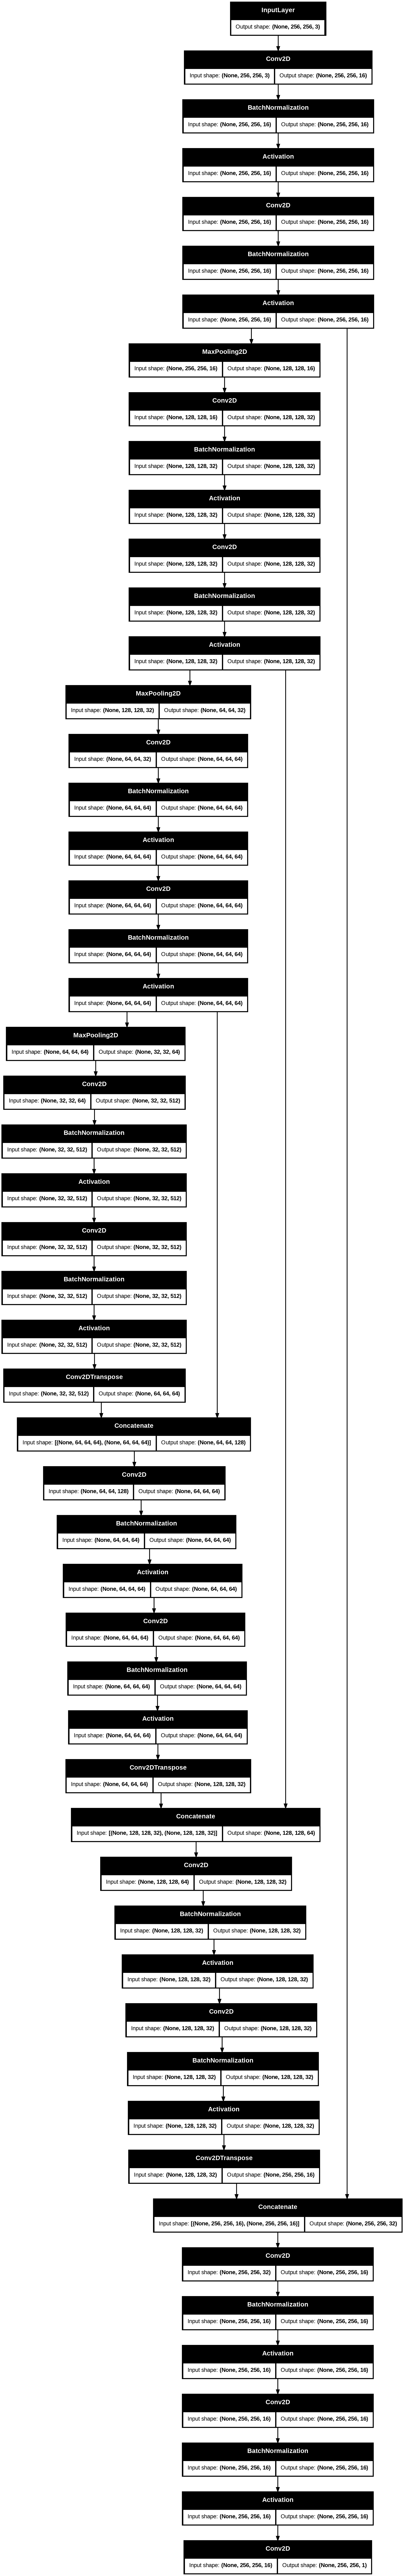

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import numpy as np




def dice_coefficient(y_true, y_pred):
    smooth = 1e-6 # prevents division by zero.
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)


Y_train = np.expand_dims(Y_train, axis=-1)
Y_val = np.expand_dims(Y_val, axis=-1)
Y_test = np.expand_dims(Y_test, axis=-1)


X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
X_val = X_val.astype('float32')
Y_val = Y_val.astype('float32')




model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient])



history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=8,

)


model.save('/kaggle/working/model.h5')

print("Model saved successfully!")

Epoch 1/50


I0000 00:00:1745862787.901404      97 service.cc:148] XLA service 0x7fedcc002870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745862787.902126      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745862787.902155      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745862789.183036      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/268 ━━━━━━━━━━━━━━━━━━━━ 2:10:34 29s/step - dice_coefficient: 0.0425 - loss: 0.9575

I0000 00:00:1745862803.666096      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


268/268 ━━━━━━━━━━━━━━━━━━━━ 60s 113ms/step - dice_coefficient: 0.0820 - loss: 0.9180 - val_dice_coefficient: 0.0408 - val_loss: 0.9593
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - dice_coefficient: 0.3901 - loss: 0.6099 - val_dice_coefficient: 0.3438 - val_loss: 0.6566
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - dice_coefficient: 0.5625 - loss: 0.4375 - val_dice_coefficient: 0.3161 - val_loss: 0.6845
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - dice_coefficient: 0.5996 - loss: 0.4004 - val_dice_coefficient: 0.4223 - val_loss: 0.5778
Epoch 5/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 27s 99ms/step - dice_coefficient: 0.6479 - loss: 0.3521 - val_dice_coefficient: 0.5942 - val_loss: 0.4058
Epoch 6/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - dice_coefficient: 0.6614 - loss: 0.3386 - val_dice_coefficient: 0.3998 - val_loss: 0.6003
Epoch 7/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - dice_coefficient: 0.6921 - loss: 0.3079 - val_dice_coefficient: 0.6441 - v

In [ ]:
loss, dice = model.evaluate(X_test, Y_test)
print("Test Dice Coefficient:", dice)

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 418ms/step - dice_coefficient: 0.7699 - loss: 0.2305
Test Dice Coefficient: 0.7720522284507751


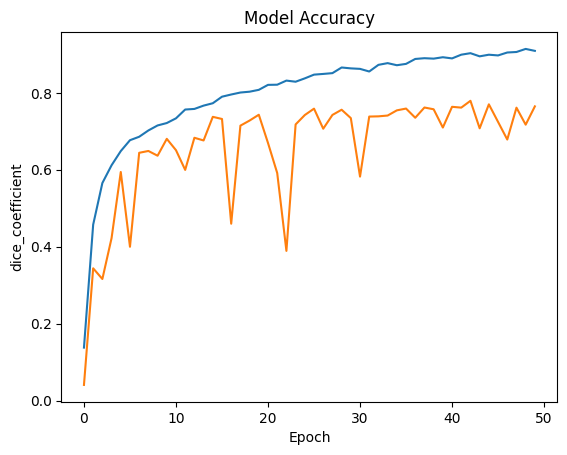

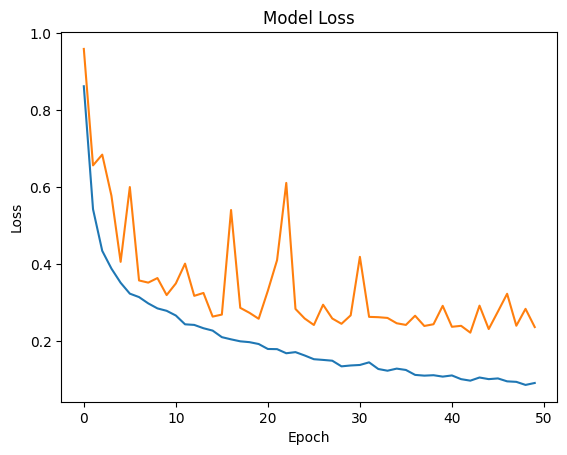

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Model Accuracy')
plt.ylabel('dice_coefficient')
plt.xlabel('Epoch')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


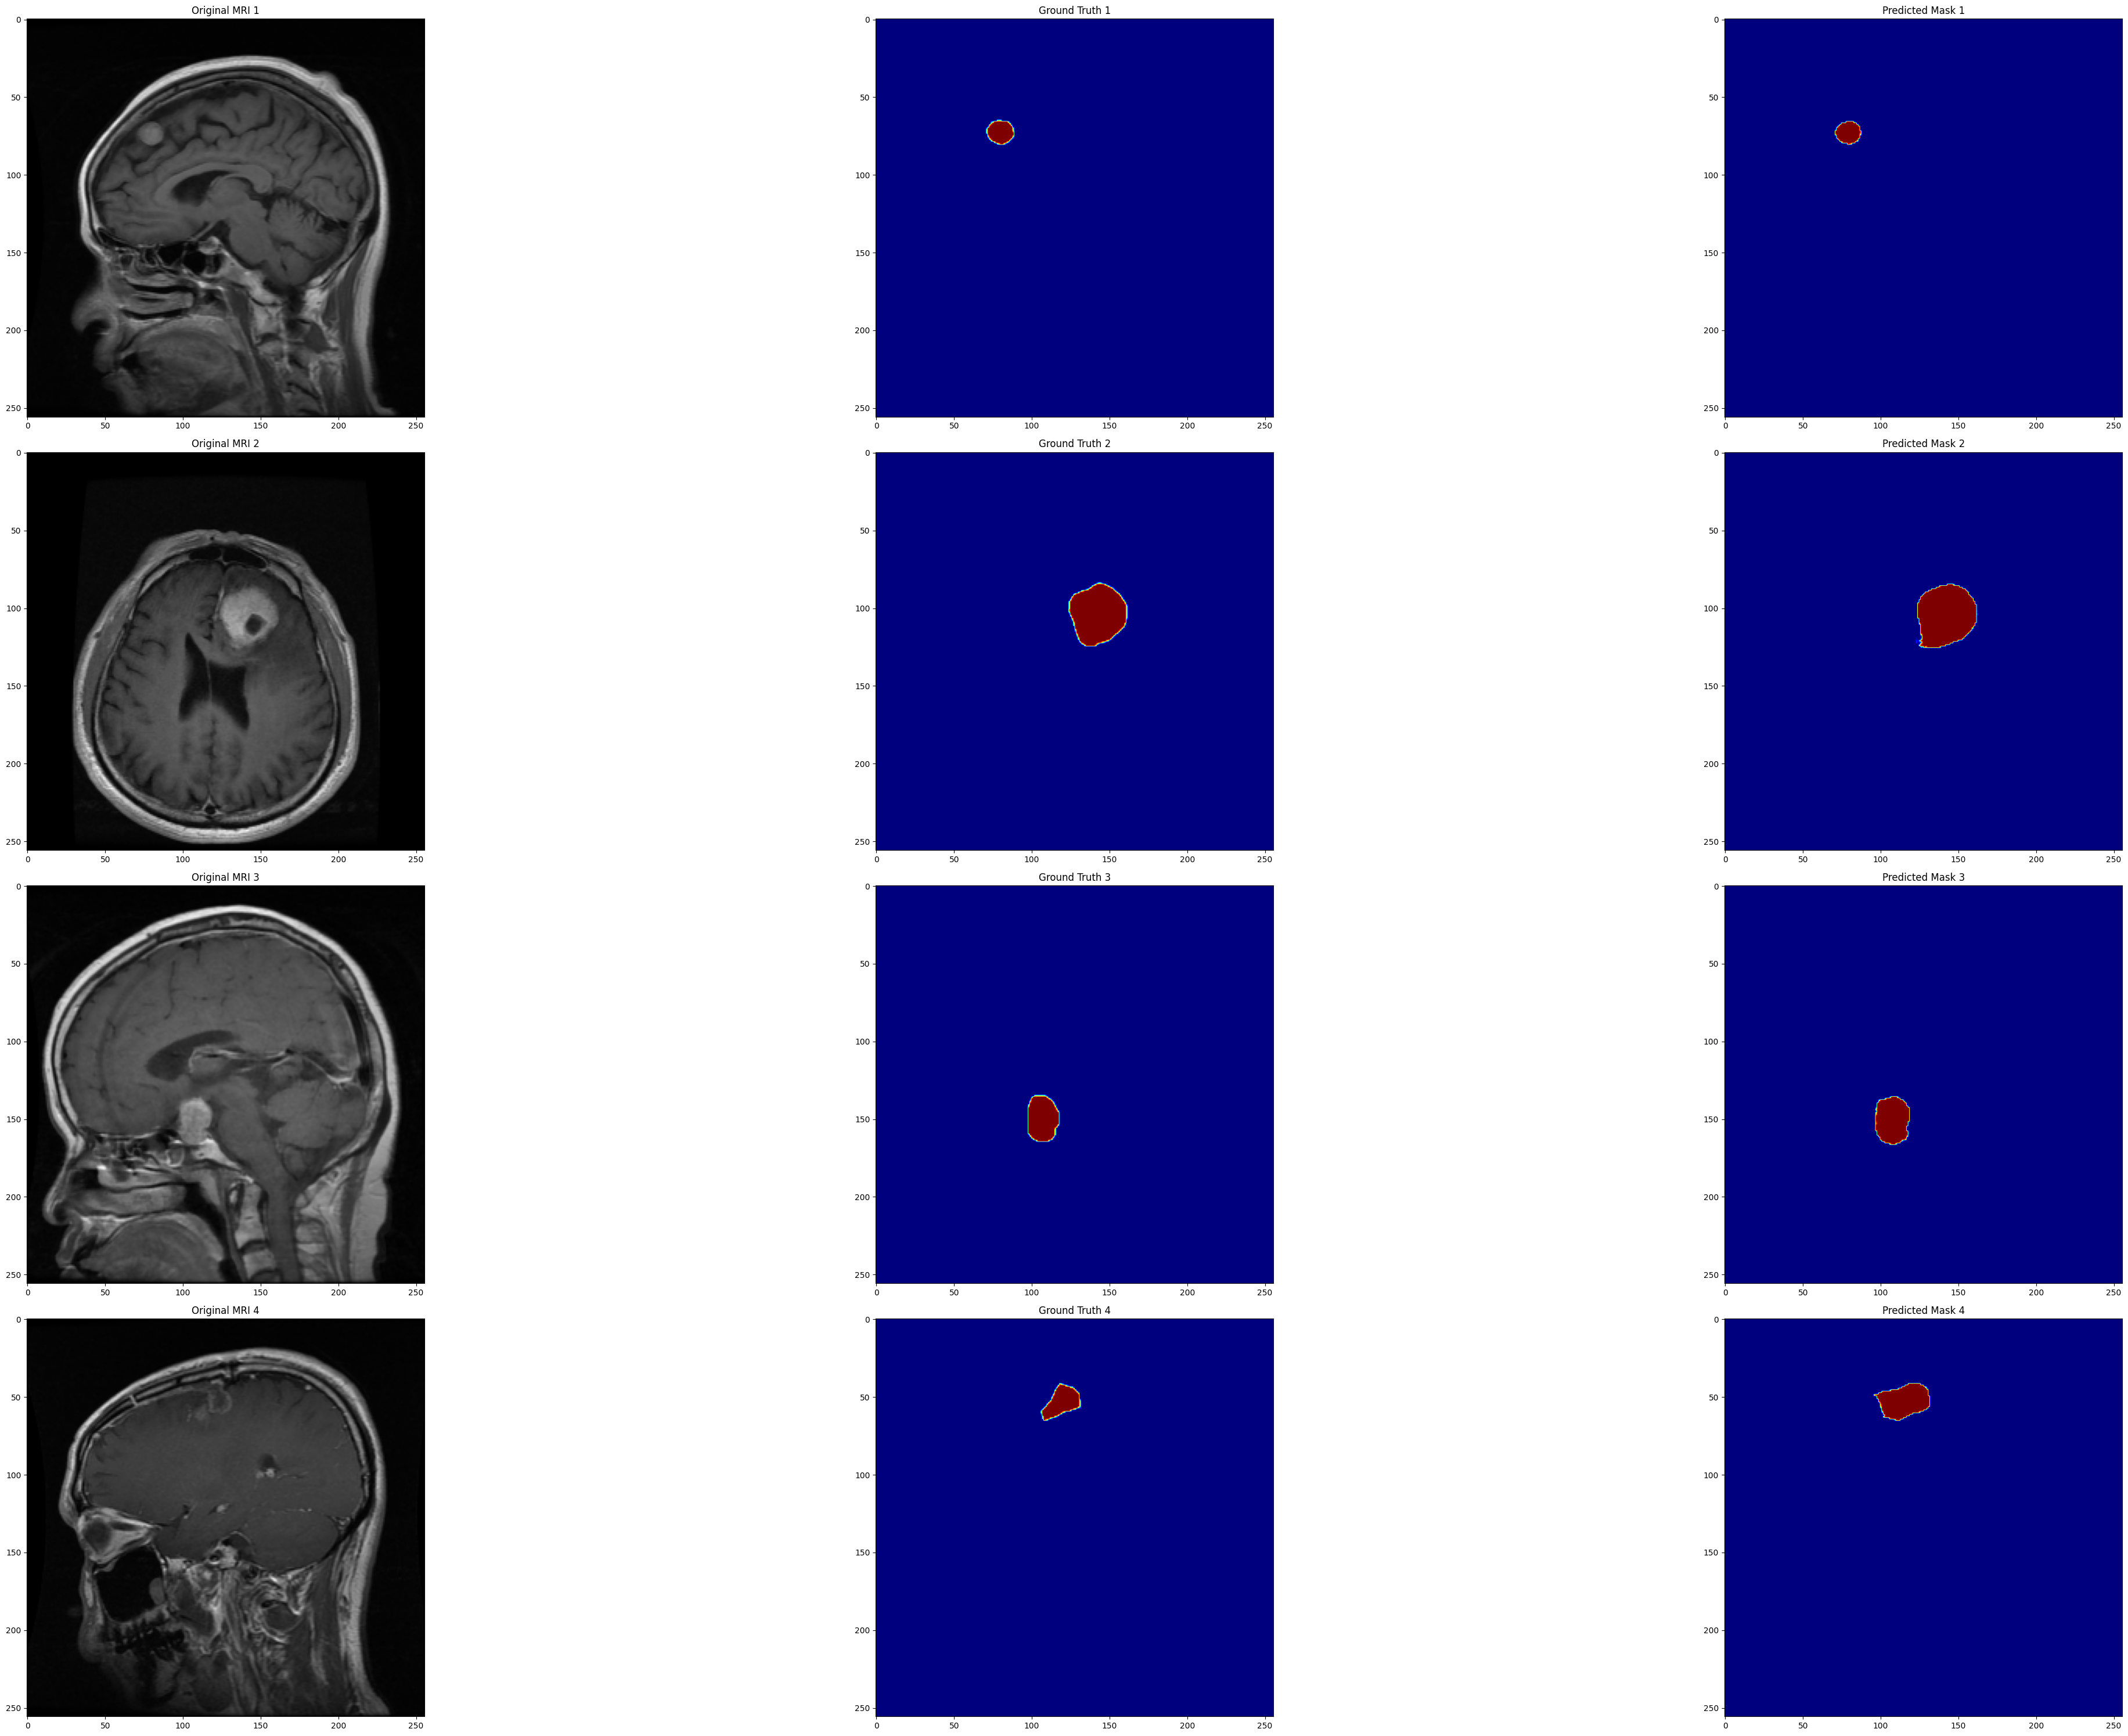

In [ ]:
import matplotlib.pyplot as plt

def visualize_prediction(model, X_test, Y_test, index=6):
    pred_mask = model.predict(X_test[index:index+4])

    plt.figure(figsize=(50, 30))

    for i in range(4):
        plt.subplot(4, 3, i * 3 + 1)
        plt.imshow(X_test[index + i].squeeze(), cmap='gray')
        plt.title(f"Original MRI {i+1}")

        plt.subplot(4, 3, i * 3 + 2)
        plt.imshow(Y_test[index + i].squeeze(), cmap='jet')
        plt.title(f"Ground Truth {i+1}")

        plt.subplot(4, 3, i * 3 + 3)
        plt.imshow(pred_mask[i].squeeze(), cmap='jet')
        plt.title(f"Predicted Mask {i+1}")

    plt.tight_layout()
    plt.show()






# Now visualize predictions
# Test on sample images from the Testing set
visualize_prediction(model, X_test, Y_test, index=6)

In [ ]:
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5


IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, Y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, Y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, Y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.8066616
Precision Score = 0.765
Recall Score = 0.783
F1 Score = 0.774
